# Example code of Segment Anything Model (SAM)

Colab 환경에서 SAM 모델을 사용해 이미지에 클릭한 위치의 객체를 segmentation 하는 예제입니다.

## Colab 환경 설정
예제를 실행시키기 위해 python package들을 설치합니다. 예제로 사용할 이미지들도 다운로드 받습니다.

In [2]:
# Local에서 Run하는 경우 False로 변경
using_colab = True

In [3]:
if using_colab:
    !wget https://raw.githubusercontent.com/mrsyee/dl_apps/main/segmentation/requirements.txt
    !pip install -r requirements.txt

    # Download examples
    !mkdir examples
    !cd examples && wget https://github.com/mrsyee/dl_apps/raw/main/segmentation/examples/dog.jpg
    !cd examples && wget https://github.com/mrsyee/dl_apps/raw/main/segmentaiton/examples/dogs2.jpg

## Import dependency

In [2]:
import os
import urllib

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from segment_anything import SamPredictor, sam_model_registry

## Set Constant

In [3]:
CHECKPOINT_PATH = os.path.join("checkpoint")
CHECKPOINT_NAME = "sam_vit_h_4b8939.pth"
CHECKPOINT_URL = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
MODEL_TYPE = "default"
IMAGE_PATH = "examples/dog.jpg"
OUTPUT_PATH = "outputs/output.jpg"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Initailize Model

[Segment Anything 라이브러리](https://github.com/facebookresearch/segment-anything)의 `SamPredictor` Class를 이용해 SAM 모델을 불러옵니다.

In [4]:
if not os.path.exists(CHECKPOINT_PATH):
    os.makedirs(CHECKPOINT_PATH, exist_ok=True)
checkpoint = os.path.join(CHECKPOINT_PATH, CHECKPOINT_NAME)
if not os.path.exists(checkpoint):
    urllib.request.urlretrieve(CHECKPOINT_URL, checkpoint)
sam = sam_model_registry[MODEL_TYPE](checkpoint=checkpoint).to(DEVICE)
predictor = SamPredictor(sam)

## Inference Model

SamPredictor의 내부 함수를 이용해 추론을 수행하여 원하는 결과물을 얻습니다.

### 예제 이미지 불러오기

In [5]:
image = cv2.imread(IMAGE_PATH, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

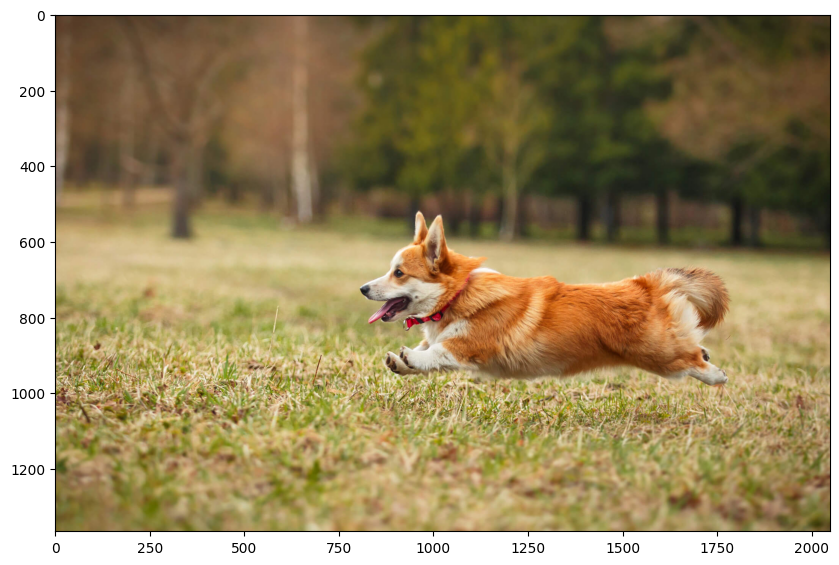

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("on")
plt.show()

### Point 입력하기

원하는 위치의 객체를 segmentation 하기 위해서는 원하는 위치를 Point로 입력해야합니다. SAM 모델에 Point를 입력하기 위해서는 두 가지 정보가 필요합니다.

- point_coords: Point 좌표 (x, y)
- points_labels: Point의 타입. Point 위치의 객체를 선택하려면 Positive Click(1)로 설정.

In [7]:
point_coords = np.array([[1000, 700]])
points_labels = np.array([1])

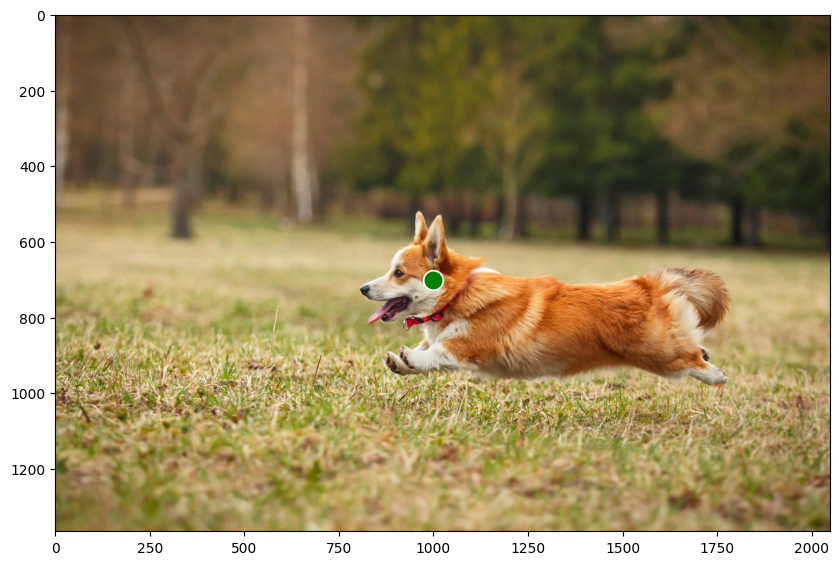

In [17]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.gca().scatter(point_coords[0, 0], point_coords[0, 1], color='green', marker='o', s=200, edgecolor='white', linewidth=1.25)
plt.axis("on")
plt.show()

### SAM 모델 추론

predictor의 predict 함수를 통해 추론합니다. 추론의 결과로 2 가지 정보가 출력됩니다.
- masks: 입력한 정보에 대해 3개의 mask가 출력.
- scores: 3개의 mask의 퀄리티에 대한 모델의 평가 점수. 점수가 가장 높을수록 퀄리티가 높은 mask입니다.
- low_res_logits: 저해상도 mask 출력. 이 예제에서는 사용하지 않습니다.

In [9]:
predictor.set_image(image)
masks, scores, _ = predictor.predict(point_coords, points_labels)

Mask 0


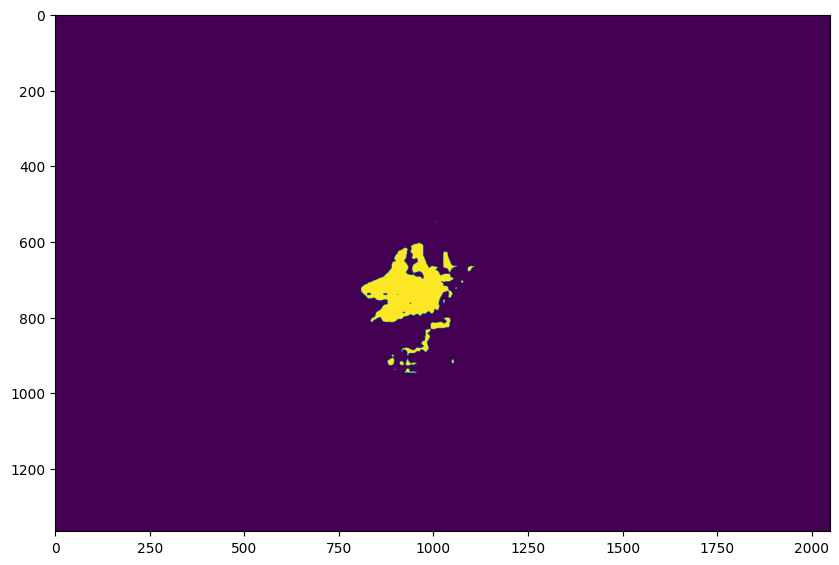

Mask 1


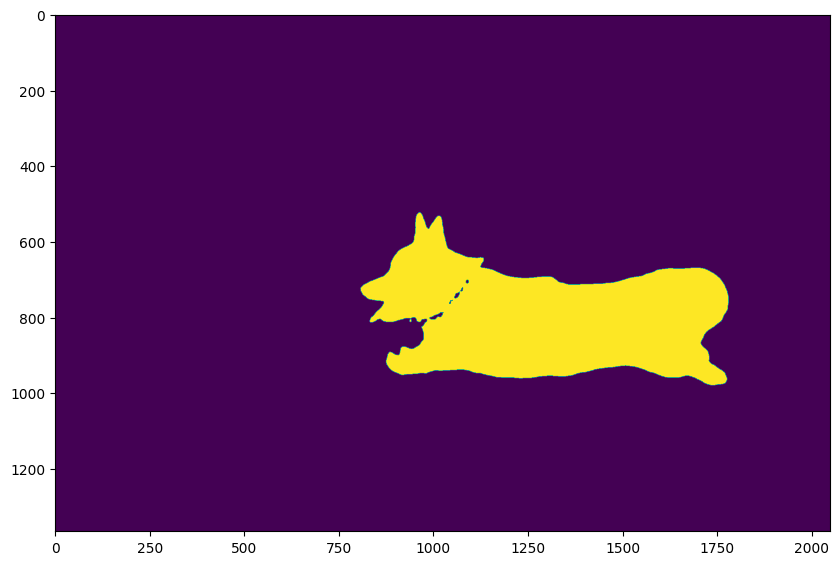

Mask 2


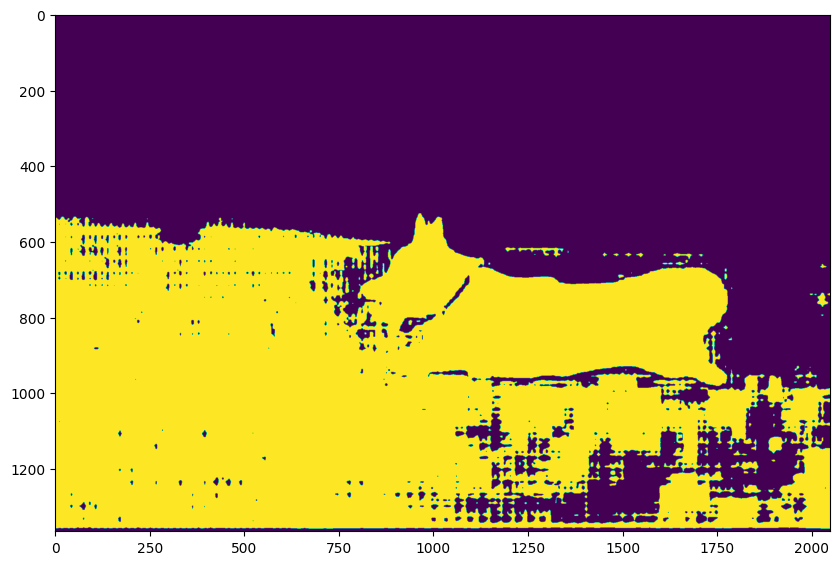

In [10]:
for i, mask in enumerate(masks):
    print(f"Mask {i}")
    plt.figure(figsize=(10, 10))
    plt.imshow(mask)
    plt.axis("on")
    plt.show()

In [11]:
scores

array([0.4957593 , 0.9951837 , 0.94646823], dtype=float32)

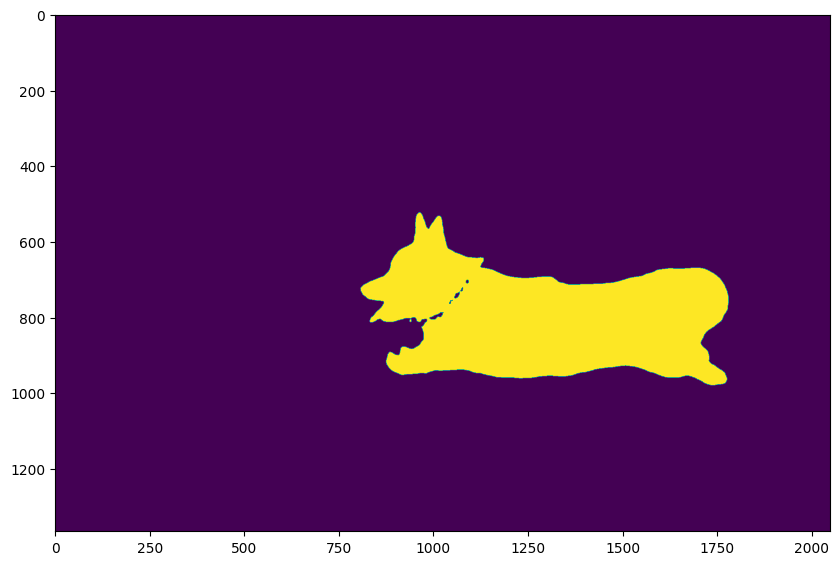

In [12]:
mask = masks[np.argmax(scores)]

plt.figure(figsize=(10, 10))
plt.imshow(mask)
plt.axis("on")
plt.show()

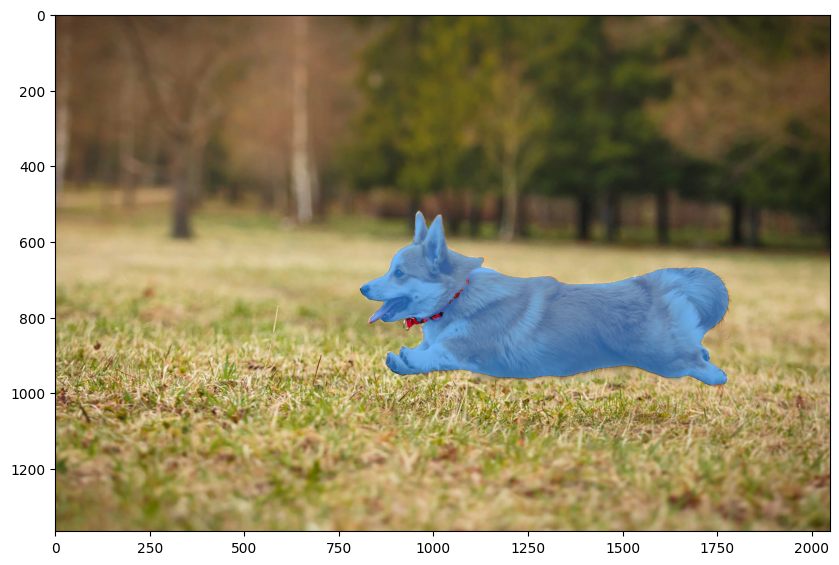

In [31]:
mask = mask.astype(np.uint8) * 255
color = np.array([30/255, 144/255, 255/255, 0.6])
mask_image = np.expand_dims(mask, axis=-1) * color.reshape(1, 1, -1)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.imshow(mask_image)
plt.axis("on")
plt.show()